# Tutorial for generating reliability field maps and gradient flow vectors:

## Reliability Field maps:  
Field maps show the contribution of the intra (x-axis) and inter (y-axis) variation to the ICC in a two dimensional histogram.

The field maps can be created using any measurable variable, but we focus on edges from a functional connectivity matrix. For a given edge, we plot the intra- and inter-variation on the x- and y-axis respectively revealing ICC (intra- and between-variation) via diagonal lines originating from point 0,0 in a rainbow-like manner. 

## Gradient flow vectors:
Built upon the variability field map, we also utilize the variability gradient flow map (GFM) for assessing the relative impact of reliability optimizations focused on one form of variation versus the other, depending on the current balance of the intra- and inter-individual variations. This allows us to identify how and where the difference in variability between two conditions changes in an optimal or sub-optimal direction towards the highest 

The gradient vector on the field map represents the optimal direction for maximal ICC change on the respective axes of individual variability. For a given ICC change, we normalized its gradient by the contributions of individual variability as compared to the optimal direction

## Data used:
 * Functional
     * N<sub>subs</sub> x edges from upper triangle of functional connectivity matrix
 * Behavioral
     * N<sub>subs</sub> x 68 behavioral measures “Cognition”, “Emotion”, “Personality” (check “Motor” and “Sensory”)

## Generating reliability field maps:
 * For this tutorial we compare functional connectivity from data processed with GSR and without GSR.
 * After importing libraries we load in results generated from our relibility model, most importantly ICC, raw intra-individual variation, raw inter-individual variation which we will use for both reliability field maps and gradient flow maps.
 * Light grey lines from the origin, (0,0), mark ICC values starting from 0.1 (shallowest angled bottom line) to 0.9 (steepest most left) - ICC of 0 and 1 are the X and Y axes respectively.
 * We will first create individual field maps with the function **single_fieldmap()**.
 * Overlaying the individual field maps with just the contour lines allows visual comparison of inter- and intra-individual variation on ICC (**field_map_overlay()**).
 
## Generating gradient flow vector angular histograms:
 * Gradient flow vectors are useful understand optimality of change in variation with respect to improved reliability. Gradient flow angular histograms show the frequency of edges for each angle.
 * Gradient flow histograms are created using **gradient_flow_histogram()**.
     * 1. intra- and inter-individual variation is used to calculate standardized gradient flow vectors and the count for each angle is plotted.
     * 2. Each angle is counted and the total number is plotted according to the gradient flow circular colormap.
 
## Generating surface plots for ICC differences and parcel-wise gradient flow vectors:
 * Mean of ICC differences and mean gradient flow vector direction for each parcel connectivity vector (row/column of ICC/gradient flow matrix) are plotted on the cortical surface with **plot_surface()** .
 * **calc_icc_vectors_mean()** first calculates standardized gradient flow vectors using the parcel vector mean of inter- and intra-individual differences to yield mean gradient flow vector direction for each parcel.
     * Separate surface plots are generated for positive and negative ICC difference and gradient flow direction for clarity.
     * Due to averaging across the parcel connectivity vector, ICC difference and gradient flow direction might not have complete congruency. 

#### Import functions needed for field maps and gradient flow vectors

In [2]:
%matplotlib inline
import os,sys
import cifti
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import surface,plotting
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('../code')
from gradient_flow_vectors import *
from reliability_field_maps import *
from variability_utils import *

/anaconda2/envs/py36/lib/python3.6/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


#### Load surfaces to plot ICC differences and gradient flow vectors on the surface

In [3]:
# Conte surface
lsurf = surface.load_surf_mesh('../misc/surfaces/Conte69.L.very_inflated.10k_fs_LR.surf.gii')
rsurf = surface.load_surf_mesh('../misc/surfaces/Conte69.R.very_inflated.10k_fs_LR.surf.gii')

# Surface plot background
bg = nib.load('../misc/surfaces/100206.sulc.10k_fs_LR.dscalar.nii').get_fdata()

# Example file to save surface plots
plabel = '../misc/Glasser2016_labels/HCP_MMP_P210_10k.dlabel.nii'
glasserlabel,(ax1,ax2) = cifti.read(plabel)
numverts = glasserlabel.shape[1]

#### Load colormaps and set gradient flow vector options:

In [4]:
# Colormaps
rvb = vector_cmap() # Gradient flow vector colormap
yeo_colors = get_yeo_colors() # Yeo 7 network colors in RGB
allparcels = get_yeo_parcels() # Glasser 360 parcels to Yeo 7 network assignments

# Set colormaps/colors for field map contours
taskcolors = {'2subsets_1200TRx1seg_REST1_LR_gsr':'grey',
 '2subsets_1200TRx1seg_REST1_LR_nogsr':'red'}
taskcmaps = {'2subsets_1200TRx1seg_REST1_LR_gsr':'Greys',
 '2subsets_1200TRx1seg_REST1_LR_nogsr':'Reds'}

# Vector plot options:
outpath = False
vector_type = 'norm_0' # raw, norm, norm_0
alpha = 1 # plot option
# savefolder = '../figures'

#### Load GSR vs no GSR data as dictionary:
 * ICC
 * raw intra-individual variation
 * raw inter-individual variation
 * total variation
 * mask of failed edges
 
"path" should be directory folder where ICC model outputs for each task are located in .csv format.

Outputs should benamed "resultsBasename_" followed by "\_[intra-individual,inter-individual,icc,vartotal]_vector.csv"



In [ ]:
# Load Data:
path = '../tutorial/example_data/icc_output'
tasks = ['2subsets_1200TRx1seg_REST1_LR_nogsr','2subsets_1200TRx1seg_REST1_LR_gsr']
data = load_data(tasks,path,resultsBasename)

#### First obtain descriptives on GSR and no GSR ICC:

In [5]:
for task in data.keys():
    print('%s: %s +/- %s' % (task,np.mean(data[task]['icc']),np.std(data[task]['icc'])))

2subsets_1200TRx1seg_REST1_LR_nogsr: 0.28950827496899895 +/- 0.18291359447808447
2subsets_1200TRx1seg_REST1_LR_gsr: 0.2781916648771391 +/- 0.19336343790428093


Resting-state scans processed without GSR have greater mean ICC (0.29 +/- 0.18) compared to scans processed with GSR (0.28 +/- 0.19)

In the following, we look at how inter- and intra-individual variation contribute to ICC differences.

## 1. Individual fieldmaps for GSR and no GSR
 * _tasks_, _taskcolors_, _taskcmaps_ should include all conditions included in _data_

2subsets_1200TRx1seg_REST1_LR_nogsr


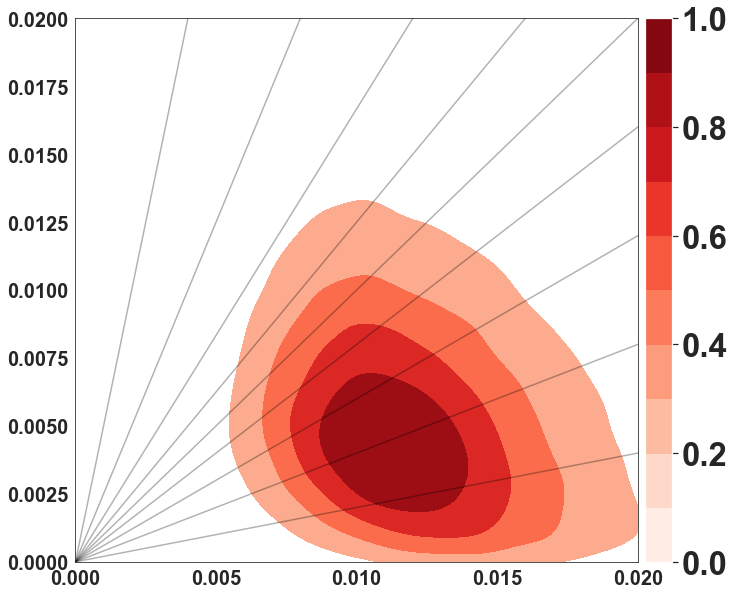

2subsets_1200TRx1seg_REST1_LR_gsr


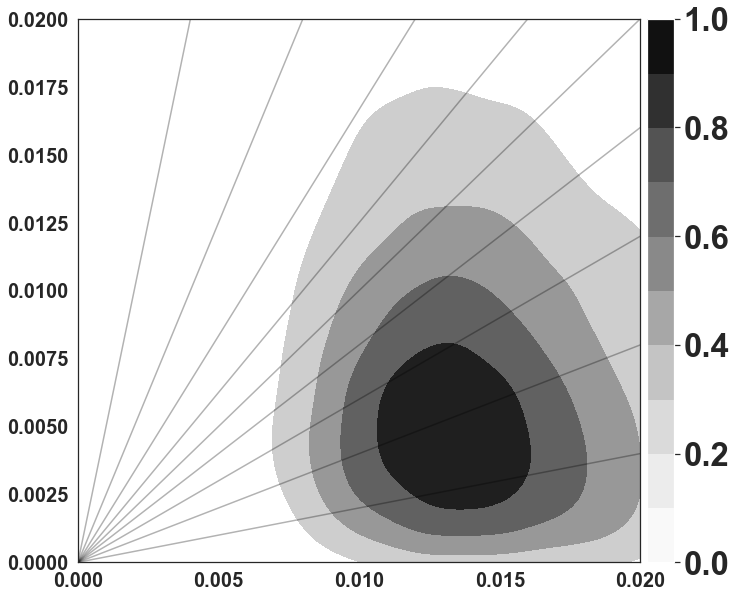

In [6]:
# Not saving any figures for now.
outpath = False
lines = False
alpha = 1
# Plot individual field maps:
field_map(tasks,data,taskcolors,taskcmaps,alpha,lines,outpath)

## 2. Field map overlap for GSR and no GSR

2subsets_1200TRx1seg_REST1_LR_nogsr
2subsets_1200TRx1seg_REST1_LR_gsr


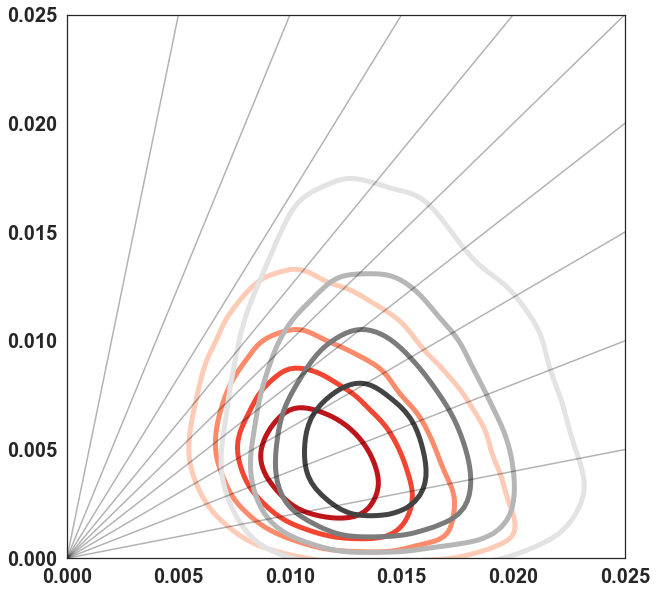

In [64]:
# Not saving any figures for now.
outpath = False

# Choosing conditions to compare:
taskcombos = [['2subsets_1200TRx1seg_REST1_LR_nogsr',
                '2subsets_1200TRx1seg_REST1_LR_gsr']]

# Plot field map comparisons:
field_map_overlay(taskcombos,data,taskcolors,taskcmaps,outpath)

## Gradient flow vector angular histogram:

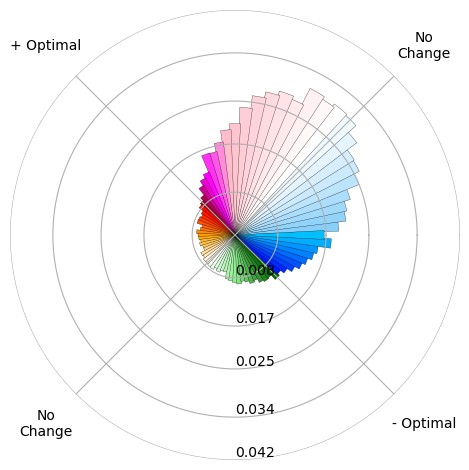

In [81]:
# Gradient flow histogram plot options:
vector_type = 'norm_0' # raw, norm, norm_0
bin_threshold = 5 # degrees covered per histogram bar
outpath = False # No saving for now.
title = False # No title for now.
num_parc = 360 # Using only cortical edges for now.

# Tasks for comparison:
tasks = ['2subsets_1200TRx1seg_REST1_LR_nogsr',
         '2subsets_1200TRx1seg_REST1_LR_gsr']

# Plot gradient flow histogram:
gradient_flow_histogram(tasks,data,vector_type,num_parc,
                            bin_threshold,title,outpath)


## GSR vs No GSR surface

Every 4 Surface plots in order shown (Left lateral, left medial, right lateral, right medial:
1. Positive change gradient flow vectors
2. Positive change ICC
3. Negative change gradient flow vectors
4. Negative change ICC


../code/gradient_flow_vectors.py:102: RuntimeWarning: invalid value encountered in true_divide
  angle0 = np.arctan(y0/x0)
../code/variability_utils.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,15))
/anaconda2/envs/py36/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figsize=figsize)


<Figure size 720x1080 with 0 Axes>

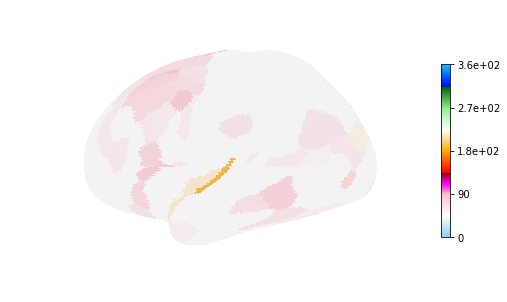

<Figure size 720x1080 with 0 Axes>

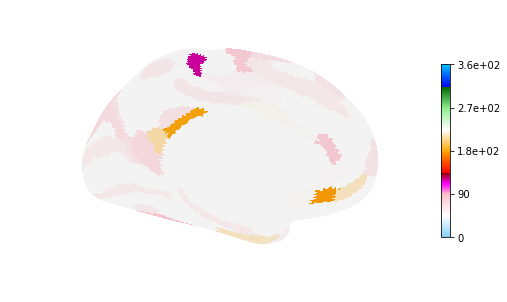

<Figure size 720x1080 with 0 Axes>

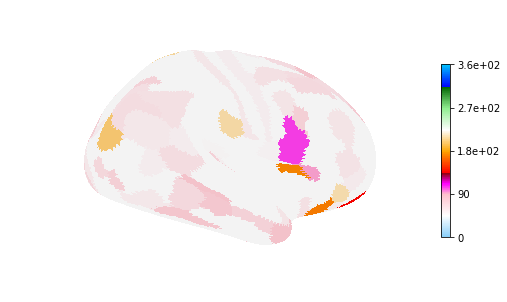

<Figure size 720x1080 with 0 Axes>

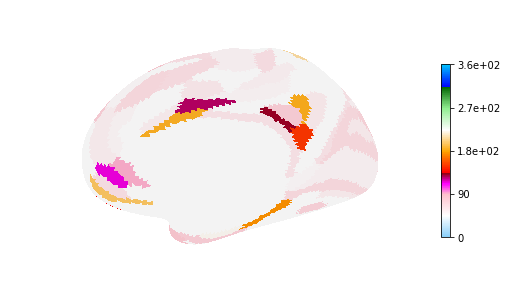

<Figure size 720x1080 with 0 Axes>

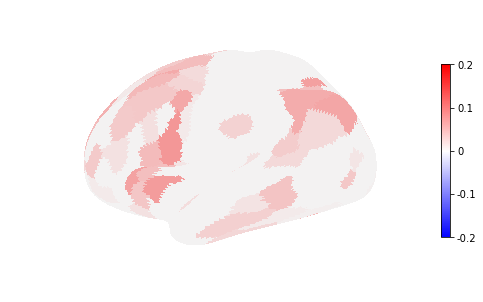

<Figure size 720x1080 with 0 Axes>

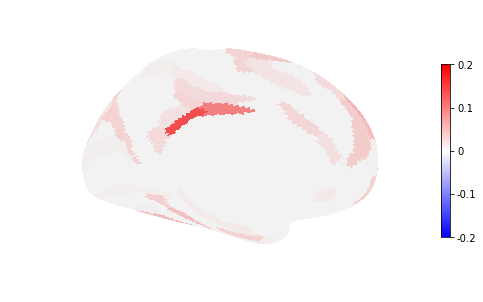

<Figure size 720x1080 with 0 Axes>

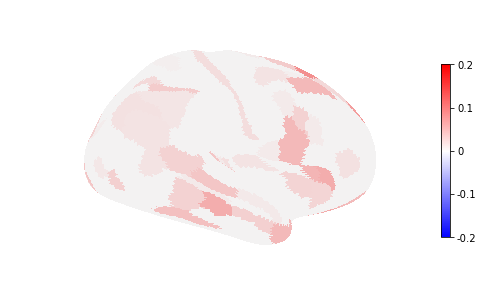

<Figure size 720x1080 with 0 Axes>

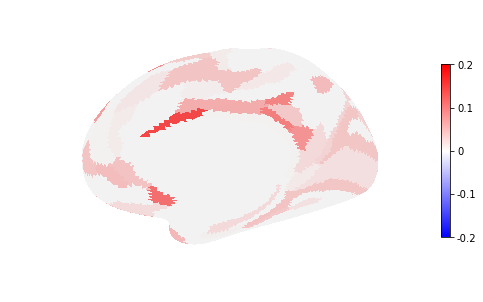

<Figure size 720x1080 with 0 Axes>

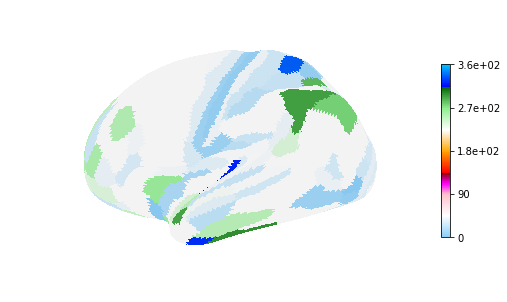

<Figure size 720x1080 with 0 Axes>

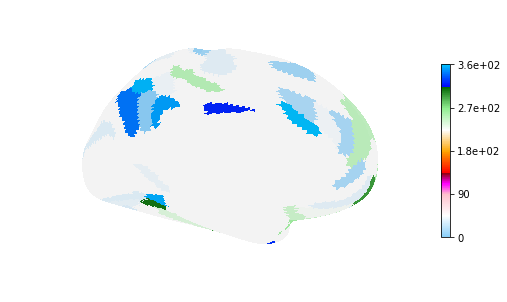

<Figure size 720x1080 with 0 Axes>

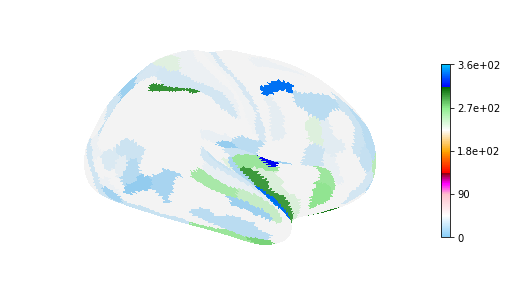

<Figure size 720x1080 with 0 Axes>

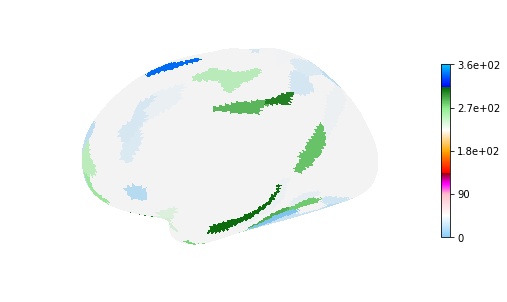

<Figure size 720x1080 with 0 Axes>

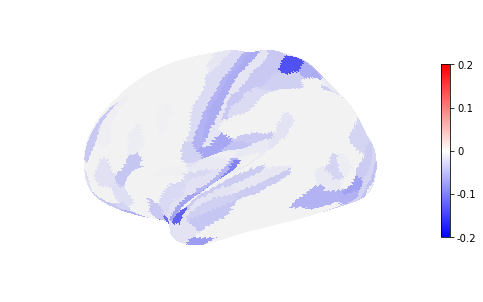

<Figure size 720x1080 with 0 Axes>

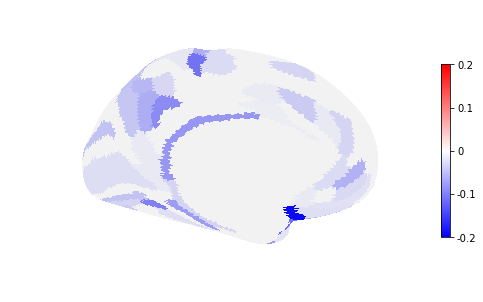

<Figure size 720x1080 with 0 Axes>

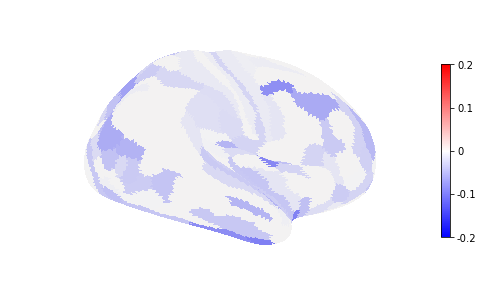

<Figure size 720x1080 with 0 Axes>

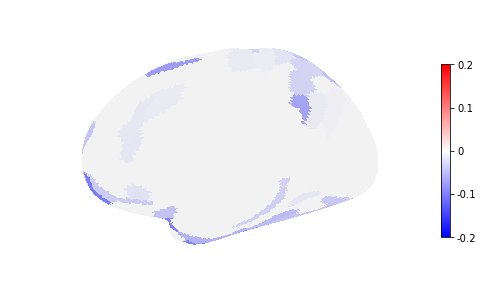

In [6]:
taskcombos = [['2subsets_1200TRx1seg_REST1_LR_nogsr','2subsets_1200TRx1seg_REST1_LR_gsr']]
outpath = '../figures/shortpaper/shortpaper_new/concat_vs_contiguous/surface'
numparcels = 1
alpha = 1
glasserlabel,(ax1,ax2) = cifti.read(plabel)
surfaces = [lsurf,rsurf]
numparcels = 1
alpha = 1
darkness = 0.1
data_range = (0,360)
cmap = rvb
parcellation = glasserlabel
outpath = False
plot_surface_comparisons(taskcombos, data, parcellation, surfaces, numparcels, alpha, darkness, data_range,cmap,outpath)

While data processed without GSR has overall greater reliability compared to data processed with GSR, we can see topological differences in different brain regions as shown by surface plots showing ICC differences as well as gradient vectors. With this information different preprocessing steps can be applied when higher reliability is desired for the target region being studied. 